<a href="https://colab.research.google.com/github/woaixuexi2023/D2L--Module2--HW1/blob/main/Module4_HW2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing data
import torch
import torchvision
from torchvision.transforms import ToTensor, Normalize, Compose
from torchvision.datasets import MNIST

mnist = MNIST(root='data', 
              train=True, 
              download=True,
              transform=Compose([ToTensor(), Normalize(mean=(0.5,), std=(0.5,))]))

In [2]:
# function to denormalize and view the images. 
# This function will also be useful for viewing the generated images.
def denorm(x):
    out = (x + 1) / 2
    return out.clamp(0, 1)#any values are between 0 and 1 will be the output, if anything outside the range will be out

In [3]:
#Note that pixel values were transformed from the range [0, 1] to the range [-1, 1].
#Look at sample tensor values.
img, label = mnist[2]
print('Label: ', label)
print(img[:,10:15,10:15])
torch.min(img), torch.max(img)#check the min and max of the images

Label:  4
tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
         [-0.6157, -0.0902,  0.1294,  0.1765,  0.8902]]])


(tensor(-1.), tensor(1.))

Label: 4


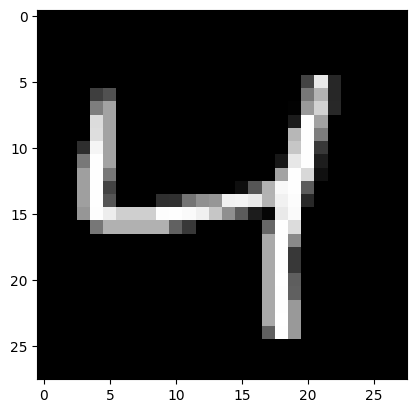

In [4]:
#graph of the normalized images
import matplotlib.pyplot as plt
%matplotlib inline

img_norm = denorm(img)
plt.imshow(img_norm[0], cmap='gray')
print('Label:', label)

In [5]:
#Create a dataloader to load the images in batches.
from torch.utils.data import DataLoader

batch_size = 20 #change batch size to 20
data_loader = DataLoader(mnist, batch_size, shuffle=True)

In [6]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [7]:
#Create the Discriminator Network
image_size = 784 # 28X28=784
hidden_size = 256 

In [8]:

#Discriminator model has 3 layers, activation function is leakyReRL(), 0.2 is the gradient of the negative balues
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),#another hidden layer with the same hidden size=256
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())#probability information between (0,1)

In [ ]:
%%time
#Improve the discriminator according to generator
import torch.nn as nn

D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),#another hidden layer with the same hidden size=256
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),    
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())#probability information between (0,1)

In [9]:
# Move the discriminator model to the chosen device.
D.to(device);

In [10]:
#Create the Genarator Network
#latent_size = 64 # random noises are from the latent_size=64
latent_size = 100 #Increase the latent_size to 100 to input more noises

In [11]:

#Generator model has 3 layers
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),#image size is 784 as the output, it should be the same as the real image size
    nn.Tanh())# activation function is between (-1, 1)

In [ ]:
%%time 
#Improve the model by adding more layers
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())     

In [12]:
# Pass the discriminator model to the chosen device.
G.to(device);

Model Train

In [ ]:
%%time
criterion = nn.BCELoss()# the loss function is binary-cross-entropy function
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)

In [ ]:
%%time
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)#create random values
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [13]:
#change the loss function to W-loss
criterion = nn.MSELoss() # the loss function is mean squared error
d_optimizer = torch.optim.RMSprop(D.parameters(), lr=0.0002) # use RMSprop optimizer for WGAN
lambda_gp = 10# this is the typical value for lambda

def train_discriminator(images):
    # Loss for real images
    real_outputs = D(images)
    d_loss_real = torch.mean(real_outputs)

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_outputs = D(fake_images)
    d_loss_fake = torch.mean(fake_outputs)

    # Gradient penalty
    epsilon = torch.rand(batch_size, 1, 1, 1).to(device)
    x_hat = epsilon * images.data + (1 - epsilon) * fake_images.data
    x_hat.requires_grad = True
    hat_outputs = D(x_hat)
    gradients = torch.autograd.grad(outputs=hat_outputs, inputs=x_hat, grad_outputs=torch.ones(hat_outputs.size()).to(device), create_graph=True, retain_graph=True, only_inputs=True)[0]
    gradient_penalty = lambda_gp * ((gradients.norm(2, dim=1) - 1) ** 2).mean()

    # Combine losses
    d_loss = d_loss_fake - d_loss_real + gradient_penalty

    # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Clip gradients
    torch.nn.utils.clip_grad_norm_(D.parameters(), max_norm=0.01)
    # Adjust the parameters using backprop
    d_optimizer.step()

    return d_loss, real_outputs, fake_outputs


In [14]:
#Change loss function for generator 
g_optimizer = torch.optim.RMSprop(G.parameters(), lr=0.0002) # use RMSprop optimizer for WGAN
def train_generator():
    # Generate fake images and calculate the outputs of the discriminator on them
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    fake_outputs = D(fake_images)

    # Calculate the Wasserstein distance and the loss
    w_distance = -torch.mean(fake_outputs)
    g_loss = w_distance

    # Reset gradients
    g_optimizer.zero_grad()

    # Compute gradients
    g_loss.backward()

    # Update the generator
    g_optimizer.step()

    return g_loss.item(), fake_images


In [ ]:
%%time #define g_optimizer function
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

In [ ]:
%%time 
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)#create the labels=1 (actually the images are fake)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images# dake_images are the output for the generatoer model

CPU times: user 5 µs, sys: 0 ns, total: 5 µs
Wall time: 10.3 µs


In [15]:
#Create a directory
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)#have the samples saved

first batch
torch.Size([20, 1, 28, 28])
tensor([3, 4, 0, 4, 3, 3, 4, 4, 1, 6, 0, 7, 1, 2, 4, 2, 8, 0, 6, 8])


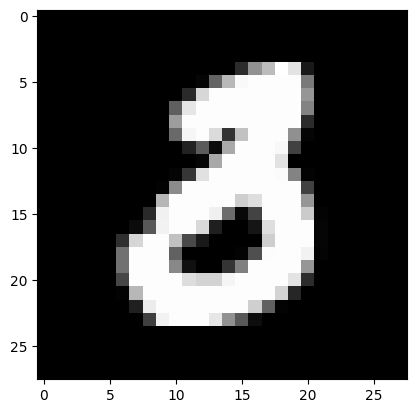

In [16]:
for img_batch, label_batch in data_loader:
    print('first batch')
    print(img_batch.shape)#check the batch size
    plt.imshow(img_batch[0][0], cmap='gray')
    print(label_batch)
    break

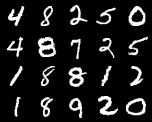

In [17]:
#Use a batch of images from data loader
from IPython.display import Image
from torchvision.utils import save_image

# Save some real images
for images, _ in data_loader:
    images = images.reshape(images.size(0), 1, 28, 28)
    save_image(denorm(images), os.path.join(sample_dir, 'real_images.png'), nrow=5)#save the images follow the path
    break
   
Image(os.path.join(sample_dir, 'real_images.png'))#saved by batch with bath_size=20

Saving fake_images-0000.png


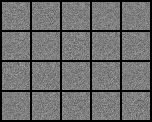

In [18]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 1, 28, 28)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)#the saved fake images name
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=5)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))
#no images in the beginning

In [ ]:
%%time #take about 1 hour

num_epochs = 100 #to save time change 300 to 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], [] #create dloss, gloss, realscore, and fakescore

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)#for each epoch, after each 200 steps, the loss and score results will be recorded

Epoch [0/100], Step [200/3000], d_loss: 0.0432, g_loss: 3.9124, D(x): 0.99, D(G(z)): 0.04
Epoch [0/100], Step [400/3000], d_loss: 0.2364, g_loss: 4.3618, D(x): 0.99, D(G(z)): 0.19
Epoch [0/100], Step [600/3000], d_loss: 0.0400, g_loss: 4.7963, D(x): 0.98, D(G(z)): 0.02
Epoch [0/100], Step [800/3000], d_loss: 0.0428, g_loss: 7.7700, D(x): 0.97, D(G(z)): 0.01
Epoch [0/100], Step [1000/3000], d_loss: 0.1234, g_loss: 4.6654, D(x): 0.91, D(G(z)): 0.02
Epoch [0/100], Step [1200/3000], d_loss: 0.0965, g_loss: 4.8589, D(x): 0.99, D(G(z)): 0.08
Epoch [0/100], Step [1400/3000], d_loss: 0.0951, g_loss: 4.0431, D(x): 0.98, D(G(z)): 0.07
Epoch [0/100], Step [1600/3000], d_loss: 0.1727, g_loss: 4.5964, D(x): 0.90, D(G(z)): 0.04
Epoch [0/100], Step [1800/3000], d_loss: 0.2719, g_loss: 3.5215, D(x): 0.94, D(G(z)): 0.16
Epoch [0/100], Step [2000/3000], d_loss: 0.3068, g_loss: 2.4037, D(x): 0.92, D(G(z)): 0.12
Epoch [0/100], Step [2200/3000], d_loss: 0.5085, g_loss: 2.6494, D(x): 0.84, D(G(z)): 0.13
Epo

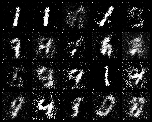

In [ ]:
Image('./samples/fake_images-0010.png')

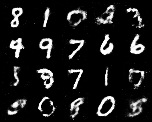

In [ ]:
Image('./samples/fake_images-0050.png')

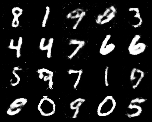

In [ ]:
Image('./samples/fake_images-0090.png')

The fake iamges are more and more clear!

In [ ]:
%%time 
#Training for the inproved model(more layers and more noises)
num_epochs = 100 #to save time change 300 to 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], [] #create dloss, gloss, realscore, and fakescore

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)#for each epoch, after each 200 steps, the loss and score results will be recorded

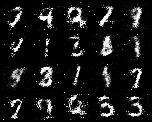

In [ ]:
Image('./samples/fake_images-0010.png')

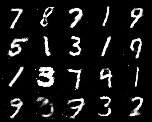

In [ ]:
Image('./samples/fake_images-0050.png')

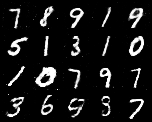

In [ ]:
Image('./samples/fake_images-0090.png')

Chnage loss function

In [19]:
def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()


In [20]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss.detach(), fake_images


In [21]:
#Model 3
num_epochs = 200 #to save time change 300 to 100
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], [] #create dloss, gloss, realscore, and fakescore

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size, -1).to(device)
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)#for each epoch, after each 200 steps, the loss and score results will be recorded


Epoch [0/200], Step [200/3000], d_loss: 9.7754, g_loss: 0.2999, D(x): 0.81, D(G(z)): 0.68
Epoch [0/200], Step [400/3000], d_loss: 9.5438, g_loss: 0.7926, D(x): 0.98, D(G(z)): 0.62
Epoch [0/200], Step [600/3000], d_loss: 9.8820, g_loss: 0.5513, D(x): 0.94, D(G(z)): 0.91
Epoch [0/200], Step [800/3000], d_loss: 9.8149, g_loss: 0.7660, D(x): 0.90, D(G(z)): 0.84
Epoch [0/200], Step [1000/3000], d_loss: 9.1268, g_loss: 0.9817, D(x): 0.91, D(G(z)): 0.20
Epoch [0/200], Step [1200/3000], d_loss: 9.5439, g_loss: 0.9685, D(x): 0.88, D(G(z)): 0.60
Epoch [0/200], Step [1400/3000], d_loss: 9.4956, g_loss: 0.9754, D(x): 0.97, D(G(z)): 0.59
Epoch [0/200], Step [1600/3000], d_loss: 9.3421, g_loss: 0.9826, D(x): 0.90, D(G(z)): 0.41
Epoch [0/200], Step [1800/3000], d_loss: 9.0452, g_loss: 0.8545, D(x): 0.90, D(G(z)): 0.03
Epoch [0/200], Step [2000/3000], d_loss: 9.0444, g_loss: 0.4797, D(x): 0.86, D(G(z)): 0.01
Epoch [0/200], Step [2200/3000], d_loss: 9.2547, g_loss: 0.8536, D(x): 0.70, D(G(z)): 0.05
Epo

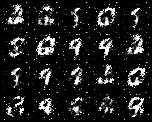

In [25]:
Image('./samples/fake_images-0010.png')

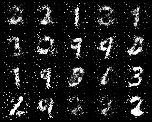

In [29]:
Image('./samples/fake_images-0020.png')

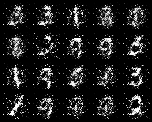

In [28]:
Image('./samples/fake_images-0030.png')

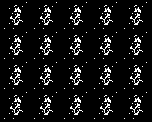

In [33]:
Image('./samples/fake_images-0100.png')

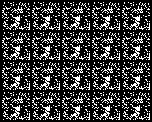

In [31]:
Image('./samples/fake_images-0180.png')

In the case of Wasserstein GANs, the use of Wasserstein loss function is known to provide more stable training than traditional GANs. However, it can be more challenging to train because of the Lipschitz constraint on the discriminator.

If the generated images are not clear, it could be due to several reasons, such as:

Insufficient training: The model may need to be trained for a longer time to generate clear images.
Suboptimal hyperparameters: The learning rate, batch size, and the number of layers in the generator and discriminator can affect the quality of the generated images. You may need to experiment with different hyperparameters to find the optimal values.
Insufficient diversity in the data: The dataset may not have enough diversity to capture all the variations in the real images. You may need to use a larger or more diverse dataset.
Poor architecture: The generator and discriminator architecture may not be suitable for the type of images you are trying to generate. You may need to try different architectures or modify the existing ones to improve the quality of the generated images.

How to improve the quality of images?

Increasing the size and complexity of the neural network models: Increasing the number of layers or neurons in the generator and discriminator models can improve their ability to learn more complex patterns and produce better quality images.

Adding noise to the input data: Adding random noise to the input data can help to introduce more variation and randomness into the generated images.

Using different optimization techniques: Changing the optimizer or adjusting the learning rate can help to improve the training process and produce better quality images.

Using different loss functions: Experimenting with different loss functions, such as the Wasserstein loss or the perceptual loss, can help to improve the quality of the generated images.

Using pre-trained models: Pre-trained models, such as a pre-trained VGG network, can be used to extract features from the generated images and ensure that they have similar features to real images.

Using data augmentation techniques: Data augmentation techniques such as rotation, translation, and scaling can be used to increase the diversity of the training data and improve the quality of the generated images.

